In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import pandas as pd

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
shutil.copyfile("/content/drive/MyDrive/png.zip", "/content/ex.zip")
shutil.unpack_archive("ex.zip","/content/png" )

In [ ]:
DATA_DIR = '/content/png'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [ ]:
inputs=[]
targets=[]
name_x=os.listdir(x_train_dir)
for i in range(len(os.listdir(x_train_dir))):
  dir=os.path.join(x_train_dir+"/"+name_x[i])
  inputs.append(dir)
name_y=os.listdir(y_train_dir)
for i in range(len(os.listdir(y_train_dir))):
  dir=os.path.join(y_train_dir+"/"+name_y[i])
  targets.append(dir)
name_x=os.listdir(x_valid_dir)
for i in range(len(os.listdir(x_valid_dir))):
  dir=os.path.join(x_valid_dir+"/"+name_x[i])
  inputs.append(dir)
name_y=os.listdir(y_valid_dir)
for i in range(len(os.listdir(y_valid_dir))):
  dir=os.path.join(y_valid_dir+"/"+name_y[i])
  targets.append(dir)


In [ ]:
test_x=[]
test_y=[]
name_a=os.listdir(x_test_dir)
for i in range(len(os.listdir(x_test_dir))):
  dir=os.path.join(x_test_dir+"/"+name_a[i])
  test_x.append(dir)
name_b=os.listdir(y_test_dir)
for i in range(len(os.listdir(y_test_dir))):
  dir=os.path.join(y_test_dir+"/"+name_b[i])
  test_y.append(dir)

In [ ]:
images = [cv2.imread(img, 0) for img in inputs]
images = [cv2.resize(img,dsize=(256,256)) for img in images]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [ ]:
masks = [cv2.imread(mask, 0) for mask in targets]
masks = [cv2.resize(mask,dsize=(256,256)) for mask in masks]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)


In [ ]:

test = [cv2.imread(tst, 0) for tst in test_x]
test = [cv2.resize(tst,dsize=(256,256)) for tst in test]
test_dataset = np.array(test)
test_dataset = np.expand_dims(test_dataset, axis = 3)

test_mask = [cv2.imread(msk, 0) for msk in test_y]
test_mask = [cv2.resize(msk,dsize=(256,256)) for msk in test_mask]
test_mask_dataset = np.array(test_mask)
test_mask_dataset = np.expand_dims(test_mask_dataset, axis = 3)

In [ ]:
test_mask_dataset.shape

(10, 256, 256, 1)

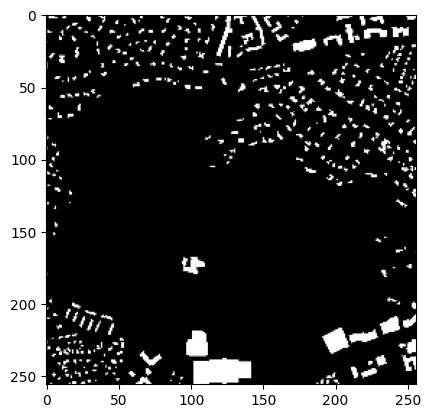

In [ ]:
plt.imshow(mask_dataset[1,:,:],cmap="gray")

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (141, 256, 256, 1)
Mask data shape is:  (141, 256, 256, 1)
Max pixel value in image is:  1.0
Labels in the mask are :  [0. 1.]


In [ ]:
mask_dataset[mask_dataset>0]=255
test_mask_dataset[test_mask_dataset>0]=255

In [ ]:
image_dataset = image_dataset /255.
mask_dataset = mask_dataset /255.
test_dataset = test_dataset /255.
test_mask_dataset = test_mask_dataset /255.
test_dataset.shape

(10, 256, 256, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

In [ ]:
mask_dataset[0]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x) 
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   



def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) 

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1: 
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4) 
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
model = build_unet(input_shape, n_classes=1)

sigmoid


In [ ]:
from keras import losses

In [ ]:

model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


Epoch 1/100
4/4 [==============================] - 47s 1s/step - loss: 0.3440 - accuracy: 0.8615 - val_loss: 0.3893 - val_accuracy: 0.8472
Epoch 2/100
4/4 [==============================] - 5s 1s/step - loss: 0.3445 - accuracy: 0.8619 - val_loss: 0.3818 - val_accuracy: 0.8473
Epoch 3/100
4/4 [==============================] - 5s 1s/step - loss: 0.3404 - accuracy: 0.8624 - val_loss: 0.3845 - val_accuracy: 0.8481
Epoch 4/100
4/4 [==============================] - 5s 1s/step - loss: 0.3395 - accuracy: 0.8628 - val_loss: 0.3800 - val_accuracy: 0.8482
Epoch 5/100
4/4 [==============================] - 5s 1s/step - loss: 0.3355 - accuracy: 0.8633 - val_loss: 0.3881 - val_accuracy: 0.8490
Epoch 6/100
4/4 [==============================] - 5s 1s/step - loss: 0.3385 - accuracy: 0.8635 - val_loss: 0.3805 - val_accuracy: 0.8485
Epoch 7/100
4/4 [==============================] - 5s 1s/step - loss: 0.3362 - accuracy: 0.8630 - val_loss: 0.3789 - val_accuracy: 0.8488
Epoch 8/100
4/4 [================

In [ ]:
y_pred=model.predict(test_dataset)

1/1 [==============================] - 6s 6s/step


In [ ]:
y_pred_thresholded=y_pred>0.5

In [ ]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, test_mask_dataset)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5747525


(1, 256, 256, 1)


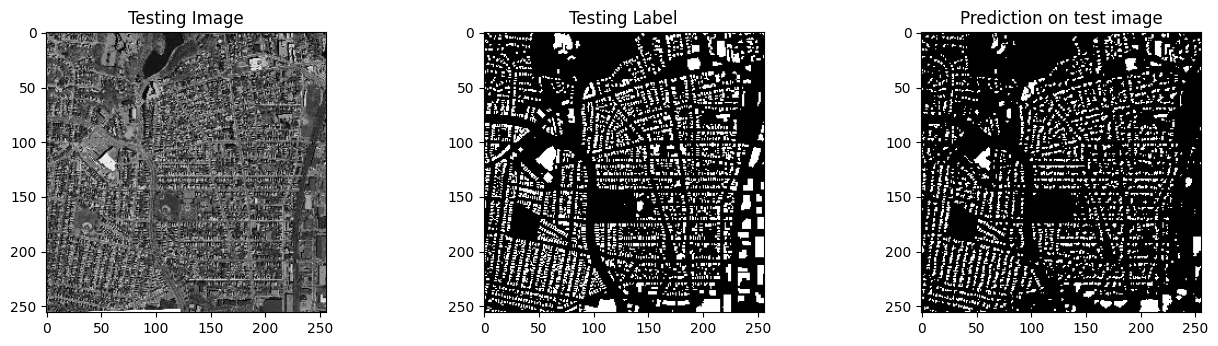

In [ ]:
import random
test_img_number = random.randint(0, len(test_dataset)-1)
test_img = test_dataset[7]
ground_truth=test_mask_dataset[7]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(y_pred_thresholded[7,:,:,0], cmap='gray')

plt.show()

In [ ]:
np.max(prediction)

0